# Example notebook for debugging your compression algorithm

This notebook shows how to import the functions from the `competition` folder, in case you want to debug using a notebook.
Remember that any code used in your entry needs to be in the `competition` folder, we will not run this notebook!

See the `README.md` for a description of how we will run your code.

In [1]:
# import your code
from competition import encode, decode, header_bits
import numpy as np
import matplotlib.pyplot as plt
from cued_sf2_lab.laplacian_pyramid import quant1, quant2, quantise, bpp
from typing import Tuple

In [2]:
# load in the image
from cued_sf2_lab.familiarisation import load_mat_img, plot_image
X1, _ = load_mat_img('lighthouse.mat', img_info='X')
X2, _ = load_mat_img('bridge.mat', img_info='X')
X3, _ = load_mat_img('flamingo.mat', img_info='X')
X4, _ = load_mat_img('SF2_competition_image_2019.mat', img_info='X')
X5, _ = load_mat_img('SF2_competition_image_2020.mat', img_info='X')
X6, _ = load_mat_img('SF2_competition_image_2021.mat', img_info='X')
X7, _ = load_mat_img('SF2_Competition_Image2022.mat', img_info='X')
X8, _ = load_mat_img('SF2_competition_image_2023.mat', img_info = 'X')

In [3]:
# encode
images_list = [X1, X2, X3, X4, X5, X6, X7, X8]
# vlc, header = encode(X)

In [4]:
# check your bitcounting function on the header
# header_bits(header)

In [5]:
from cued_sf2_lab.dwt import dwt, idwt
def nlevdwt(X, n):
    m = X.shape[0]
    Y = X.copy()
    for _ in range(n):
        Y[:m, :m] = dwt(Y[:m, :m])
        m = m//2
    return Y

def nlevidwt(Y, n):
    m = Y.shape[0]//2**(n-1)
    Z = Y.copy()
    for _ in range(n):
        Z[:m , :m] = idwt(Z[:m, :m])
        m = m*2
    return Z

In [6]:
def quantdwt(Y: np.ndarray, dwtstep: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Parameters:
        Y: the output of  dwt(X, n)
        dwtstep: an array of shape (3, n+1)
    Returns:
        Yq: the quantized version of Y
        dwtenc: an array of shape (3, n+1) containing the entropies
    """
    # your code here
    n = dwtstep.shape[1] - 1
    dwtent = np.zeros(dwtstep.shape)
    m = Y.shape[0]
    Yq = Y.copy()
    for l in range(n):
        Yq[0:m//2, m//2: m] = quantise(Yq[0:m//2, m//2:m], dwtstep[0, l])
        dwtent[0,l] = bpp(Yq[0:m//2, m//2: m])*Yq[0:m//2, m//2: m].size
        
        Yq[m//2: m, 0:m//2] = quantise(Yq[m//2: m, 0:m//2], dwtstep[1, l])
        dwtent[1,l] = bpp(Yq[m//2: m, 0:m//2])*Yq[m//2: m, 0:m//2].size
        
        Yq[m//2: m, m//2: m] = quantise(Yq[m//2: m, m//2: m], dwtstep[2, l])
        dwtent[2,l] = bpp(Yq[m//2: m, m//2: m])*Yq[m//2: m, m//2: m].size
        m = m//2
                          
    Yq[0:m, 0:m] = quantise(Yq[0:m, 0:m], dwtstep[0,n])
    dwtent[0,n] = bpp(Yq[0:m, 0:m])*Yq[0:m, 0:m].size
    
    return Yq, dwtent

In [7]:
def optimisation_equal_MSE(X, n, target_RMS, dwt_ratios, start, end, size):
    Y = nlevdwt(X, n)
    step_sizes = np.linspace(start, end, size)
    lowest = float("inf")
    
    for step in step_sizes:
        mse_dwtstep = dwt_ratios*step
        Yq, dwtent = quantdwt(Y, mse_dwtstep)
        Zq = nlevidwt(Yq, n)
        diff = abs(np.std(X - Zq) - target_RMS)
        if diff < lowest:
            lowest = diff
            output = step
        
    return output

def step_ratios(n):
    X_test = np.zeros((256, 256))
    dwt_ratios = np.ones((3, n + 1))
    m = 256
    for i in range(1, n + 1):
        Ytr = nlevdwt(X_test, i)
        Ytr[0:m//2, m//2: m][m//4][m//4] = 100
        Ztr = nlevidwt(Ytr, i)
        dwt_ratios[0][i-1] = np.sum(Ztr**2.0)
        
        Ybl = nlevdwt(X_test, i)
        Ybl[m//2: m, 0:m//2][m//4][m//4] = 100
        Zbl = nlevidwt(Ybl, i)
        dwt_ratios[1][i-1] = np.sum(Zbl**2.0)
        
        Ybr = nlevdwt(X_test, i)
        Ybr[m//2: m, m//2: m][m//4][m//4] = 100
        Zbr = nlevidwt(Ybr, i)
        dwt_ratios[2][i-1] = np.sum(Zbr**2.0)
        m = m//2
    Ytr = nlevdwt(X_test, n)
    Ytr[0:m, 0:m][m//2][m//2] = 100
    Ztr = nlevidwt(Ytr, n)
    dwt_ratios[0][n] = np.sum(Ztr**2.0)
    
    dwt_ratios = 1/np.sqrt(dwt_ratios)
    dwt_ratios = dwt_ratios/np.amax(dwt_ratios[0][0])
    dwt_ratios[-1][-1] = 0
    dwt_ratios[-2][-1] = 0
    return dwt_ratios


In [8]:
n_level = 4
# Z = decode(vlc, header)
optimised_step_size = [19.1616161616161616, 28.53535353535353535353, 25.60606060606060, 25.02020202020202, 28.2424242424242, 25.313131313131, 26.1919191919, 26.1919191919191]

This is 1
------------------------------
fdddfdff
suffecient mse step: 1
228783.85271038706
No. of bits for mse: 40640
RMS error for mse: 7.918985599403651
Compression ratios for mse: 5.629523934802831


/Users/jevonsunandar/Desktop/IIA/Projects/sf2_competition_template_team_5/competition/encoder.py:37: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  min_step = fsolve(bit_diff, x0 = jpeg2000_quant_size, args = (X_normalised))[0]


This is 2
------------------------------
fdddfdff
suffecient mse step: 1
236897.70622850963
No. of bits for mse: 40638
RMS error for mse: 12.277920528059001
Compression ratios for mse: 5.829462725245082
This is 3
------------------------------
fdddfdff
suffecient mse step: 1
245104.96477754886
No. of bits for mse: 40641
RMS error for mse: 10.759064444243158
Compression ratios for mse: 6.030977701767891
This is 4
------------------------------
fdddfdff
suffecient mse step: 1
215039.63826328865
No. of bits for mse: 40634
RMS error for mse: 10.699138697436997
Compression ratios for mse: 5.292110997275401
This is 5
------------------------------
fdddfdff
suffecient mse step: 1
245496.83175414527
No. of bits for mse: 40639
RMS error for mse: 19.599354577030045
Compression ratios for mse: 6.04091714250216
This is 6
------------------------------
fdddfdff
suffecient mse step: 1
205271.07585701058
No. of bits for mse: 40609
RMS error for mse: 8.27097945096161
Compression ratios for mse: 5.0548

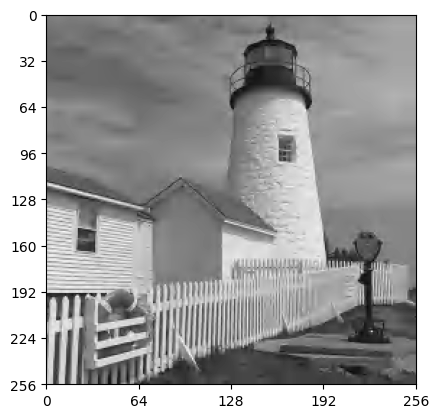

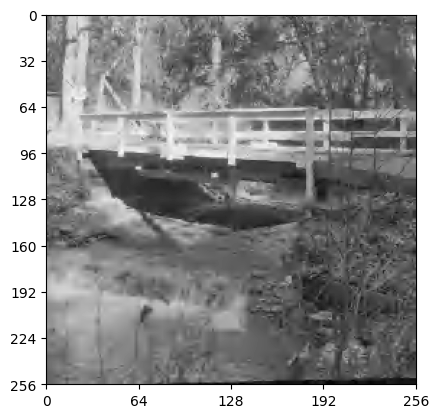

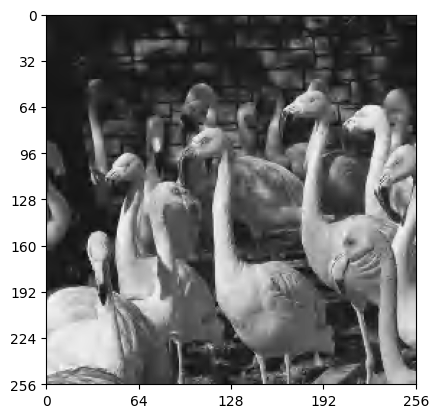

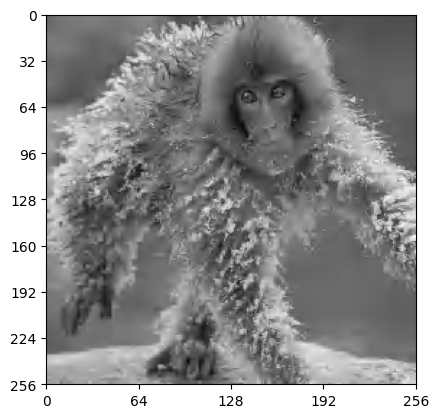

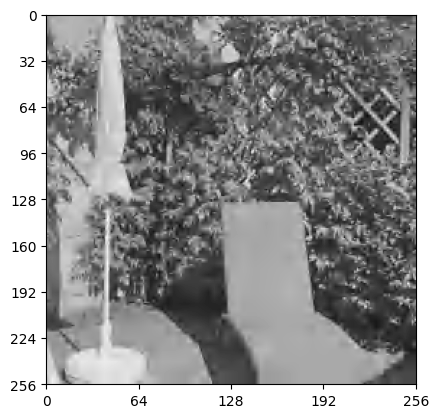

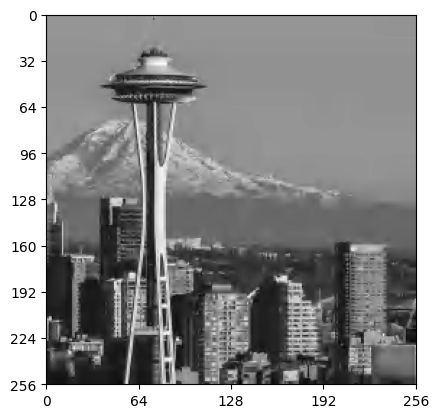

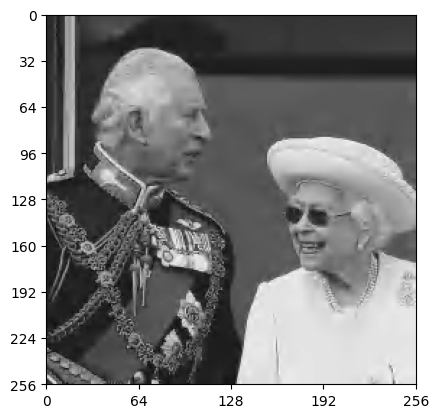

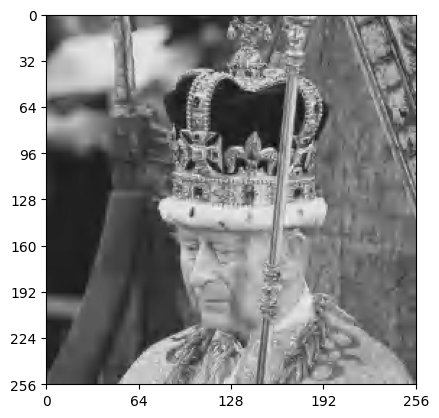

In [9]:
for i in range(len(images_list)):   
    vlc, hufftab = encode(images_list[i])
    target_rms = np.std(images_list[i] - quantise(images_list[i], 17))
    dwt_ratio = step_ratios(4)
    optimised_step = optimisation_equal_MSE(images_list[i], 4, target_rms , dwt_ratio, 1, 30 , 100)
    print("This is " + str(i + 1))
    print("-" *30)
    n = 4
    suffecient_step = 1
    ref = bpp(quantise(images_list[i], 17))*images_list[i].size

    vlc, huff = encode(images_list[i])
    Z = decode(vlc, huff)
    fig, ax = plt.subplots()
    plot_image(Z, ax = ax)
    compression_ratio_mse = ref/(sum(vlc[:, 1]) + 1424)
    print("suffecient mse step: {}".format(suffecient_step))
    print(ref)
    print("No. of bits for mse: {}".format(sum(vlc[:, 1]) + 1424))
    print("RMS error for mse: {}".format(np.std(images_list[i] - Z)))
    print("Compression ratios for mse: {}".format(compression_ratio_mse))
    
